In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from numpy import exp
from scipy import ndimage
from func import *
from astropy.table import Table, hstack
import os
import glob
from astropy.table import Table, vstack, join
import pandas as pd
from shutil import copyfile
from scipy.optimize import curvefit

In [2]:
def flux_data_err(obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    hdu = fits.open('%s/Flux Maps/%s/subcube_par_%s.fits'%(destination_path_cube,obj,obj))
    (OIII_nr,OIII_br,Hb1_blr_br,Hb2_blr_br) = (hdu[2].data,hdu[3].data,hdu[5].data,hdu[6].data)
    hdu.close()
    
    hdu = fits.open('%s/Flux Maps/%s/subcube_par_err_%s.fits'%(destination_path_cube,obj,obj))
    (OIII_nr_err,OIII_br_err,Hb1_blr_br_err,Hb2_blr_br_err) = (hdu[2].data,hdu[3].data,hdu[5].data,hdu[6].data)
    hdu.close()
    
    hdu = fits.open('%s/%s/%s_9_arcsec_empirical_factor_subcube.fits'%(destination_path_cube,obj,obj))
    central_tab = hdu[1].data
    central_columns = hdu[1].header
    (emp_Hb1,emp_Hb2,emp_wing) = (central_tab.field('emp_fact_Hb1')[0],central_tab.field('emp_fact_Hb2')[0],central_tab.field('emp_fact_wing')[0])
    hdu.close()
    
    (amp_OIII_nr,amp_OIII_br,amp_Hb1_blr_br,amp_Hb2_blr_br) = (np.max(OIII_nr),np.max(OIII_br),np.max(Hb1_blr_br),np.max(Hb2_blr_br))
    if amp_Hb1_blr_br > amp_Hb2_blr_br:
        (Hb_blr_br,amp_Hb_blr_br,Hb_blr_err,emp_Hb_blr) = (Hb1_blr_br,amp_Hb1_blr_br,Hb1_blr_br_err,emp_Hb1)
    else:
        (Hb_blr_br,amp_Hb_blr_br,Hb_blr_err,emp_Hb_blr) = (Hb2_blr_br,amp_Hb2_blr_br,Hb2_blr_br_err,emp_Hb2)
    print (emp_Hb_blr)
    (blr_err_final,wing_err_final,core_err_final) = (emp_Hb_blr*Hb_blr_err,emp_wing*OIII_br_err,OIII_nr_err)
    return Hb_blr_br,OIII_br,OIII_nr,amp_Hb_blr_br,amp_OIII_br,amp_OIII_nr,blr_err_final,wing_err_final,core_err_final
    

In [3]:
def ellip_moffat2D(p,xy,data,error):
    xy=(x,y)
    [amp, x0, y0, gamma, alpha] = p    
    g = amp*((1.0+((x-x0)/gamma)**2+((y-y0)/gamma)**2))**(-alpha)
    h = (data - g)/error
    return h.ravel()

def ellip_moffat2D_fixkin(p,xy,data,error,fixed_param):
    [gamma,alpha] = fixed_param
    xy=(x,y)
    [amp, x0, y0] = p    
    g = amp*((1.0+((x-x0)/gamma)**2+((y-y0)/gamma)**2))**(-alpha)
    h = (data - g)/error
    return h.ravel()

In [4]:
def elliptical_moffat_fit(data,error,box_size,amp,x0,y0,fix_par,MC_loops=100):
    x, y = np.mgrid[:box_size, :box_size]
    xy=(x,y)

    if fix_par is None:
        p= [amp,x0,y0,2,2]
        popt,pcov = curve_fit(ellip_moffat2D,x0=p,args=(xy,data,error),maxfev = 10000000)
        [amp_out,x0_out,y0_out,gamma_out,alpha_out]= popt
        fwhm_out = 2*gamma_out*np.sqrt(2**(1/alpha_out)-1)
        par = [amp_out,x0_out,y0_out,gamma_out,alpha_out,fwhm_out]
        mod_rav = data.ravel() - ellip_moffat2D(popt,xy,data,error)*error.ravel()
    else:
        p= [amp,x0,y0]
        popt,pcov = leastsq(ellip_moffat2D_fixkin,x0=p,args=(xy,data,error,fix_par),maxfev = 10000000)
        [amp_out,x0_out,y0_out]= popt
        par = popt
        mod_rav = data.ravel() - ellip_moffat2D_fixkin(popt,xy,data,error,fix_par)*error.ravel()
 
    model = mod_rav.reshape(box_size,box_size)
    residual = data-model
    res = (residual/error)

    parameters_MC = np.zeros((len(par),MC_loops))
    for l in range(MC_loops):
        iteration_data = np.random.normal(data,error) 
        if fix_par is None:
            p= [amp,x0,y0,2,2]
            popt_MC,pcov_MC = leastsq(ellip_moffat2D,x0=p,args=(xy,iteration_data,error),maxfev = 10000000)
            [amp_MC,x0_MC,y0_MC,gamma_MC,alpha_MC]= popt_MC
            fwhm_MC = 2*gamma_MC*np.sqrt(2**(1/alpha_MC)-1)
            par_MC = [amp_MC,x0_MC,y0_MC,gamma_MC,alpha_MC,fwhm_MC]   
            parameters_MC[:,l] = par_MC    
        else:
            p= [amp,x0,y0]
            popt_MC,pcov_MC = leastsq(ellip_moffat2D_fixkin,x0=p,args=(xy,iteration_data,error,fix_par),maxfev = 10000000)
            [amp_MC,x0_out,y0_out]= popt_MC
            parameters_MC[:,l] = popt_MC    
    parameters_err = np.std(parameters_MC,1) 
    return par,parameters_err,model,res

In [5]:
def chi_squared(data,model,err):
    res = data - model
    a = np.sum((res/err)**2)
    return a

def red_chi_squared(data,model,err,n_free):
    dof = len(data.flatten()) - n_free
    res = data - model
    k = res/err
    k[k>10**10]=0
    l = k[k!=0]
    a = np.sum(l**2)
    red = a/dof
    return red


In [6]:
def moffat_table(full_data,full_error,obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    column_names={'amp_Hb_blr':0,'x0_Hb_Blr':1,'y0_Hb_Blr':2,'gamma':3,'alpha':4,'fwhm':5,'amp_OIII_br':6,'x0_OIII_br':7,'y0_OIII_br':8,'amp_OIII_nr':9,'x0_OIII_nr':10,'y0_OIII_nr':11}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[full_data[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[full_error[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/3_arcsec_moffat_table_%s.fits'%(destination_path_cube,obj,obj),overwrite=True)

def maps(Hb_blr_br_data,OIII_br_data,OIII_nr_data,Hb_model,OIII_br_model,OIII_nr_model,Hb_res,OIII_br_res,OIII_nr_res,obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    hdus=[]
    hdus.append(fits.PrimaryHDU())
    hdus.append(fits.ImageHDU(Hb_blr_br_data,name='Hb_blr_br_data'))
    hdus.append(fits.ImageHDU(OIII_br_data,name='OIII_br_data'))
    hdus.append(fits.ImageHDU(OIII_nr_data,name='OIII_nr_data'))
    hdus.append(fits.ImageHDU(Hb_model,name='Hb_blr_br_model'))
    hdus.append(fits.ImageHDU(OIII_br_model,name='OIII_br_model'))   
    hdus.append(fits.ImageHDU(OIII_nr_model,name='OIII_nr_model'))
    hdus.append(fits.ImageHDU(Hb_res,name='Hb_blr_br_res'))
    hdus.append(fits.ImageHDU(OIII_br_res,name='OIII_br_res'))
    hdus.append(fits.ImageHDU(OIII_nr_res,name='OIII_nr_res'))
    hdu = fits.HDUList(hdus)
    hdu.writeto('%s/%s/3_arcsec_maps_%s.fits'%(destination_path_cube,obj,obj),overwrite='True')

def fluxden_compare(obj,Hb_blr_br_data,OIII_br_data,Hb_model,OIII_br_model,Hb_blr_br_err,OIII_br_err,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    f_blr_data = np.sum(Hb_blr_br_data)
    f_wing_data = np.sum(OIII_br_data)
    f_blr_model = np.sum(Hb_model)
    f_wing_model = np.sum(OIII_br_model)
    f_blr_err = np.sqrt(np.sum(Hb_blr_br_err**2))
    f_wing_err = np.sqrt(np.sum(OIII_br_err**2))
    tab_par = [f_blr_data,f_wing_data,f_blr_model,f_wing_model]
    tab_err = [f_blr_err,f_wing_err,0,0]
    column_names={'flux_blr_data':0,'flux_wing_data':1,'flux_blr_model':2,'flux_wing_model':3}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[tab_par[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[tab_err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/%s_3_arcsec_fluxden_HbOIII.fits'%(destination_path_cube,obj,obj),overwrite=True)
    
def fluxden_comp_table(obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    t1 = Table.read('%s/%s/source_%s.fits'%(destination_path_cube,obj,obj),format='fits')
    t2 = Table.read('%s/%s/%s_3_arcsec_fluxden_HbOIII.fits'%(destination_path_cube,obj,obj),format='fits')
    new = hstack([t1, t2])
    new.write('%s/%s/%s_3_arcsec_fluxden_HbOIII.fits'%(destination_path_cube,obj,obj),overwrite=True)
    
def emp_table(obj,emp_blr,emp_wing,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    popt = [emp_blr,emp_wing]
    column_names={'emp_fact_blr':0,'emp_fact_wing':1}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[popt[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/%s_3_arcsec_scaling_subcube.fits'%(destination_path_cube,obj,obj),overwrite=True)

def emp_fact_table(obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    t1 = Table.read('%s/%s/source_%s.fits'%(destination_path_cube,obj,obj),format='fits')
    t2 = Table.read('%s/%s/%s_9_arcsec_scaling_subcube.fits'%(destination_path_cube,obj,obj),format='fits')
    new = hstack([t1, t2])
    new.write('%s/%s/%s_9_arcsec_scaling_subcube.fits'%(destination_path_cube,obj,obj),overwrite=True)

In [30]:
def algorithm_script(obj,z,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):  
    print ('%s'%(obj))
    (Hb_blr_br_data,OIII_br_data,OIII_nr_data,amp_Hb_blr_br,amp_OIII_br,amp_OIII_nr,Hb_blr_br_err,OIII_br_err,OIII_nr_err) = flux_data_err(obj)
    box_size = np.shape(Hb_blr_br_data)[0]
    (brightest_pixel_Hb_blr_br_x,brightest_pixel_Hb_blr_br_y,brightest_pixel_OIII_br_x,brightest_pixel_OIII_br_y,brightest_pixel_OIII_nr_x,brightest_pixel_OIII_nr_y) = brightest_pixel_flux_map(Hb_blr_br_data,OIII_br_data,OIII_nr_data) 
    print (brightest_pixel_OIII_nr_x,brightest_pixel_OIII_nr_y)
    (Hb_par,Hb_error,Hb_model,Hb_res) = elliptical_moffat_fit(Hb_blr_br_data,Hb_blr_br_err,box_size,amp_Hb_blr_br,brightest_pixel_Hb_blr_br_x,brightest_pixel_Hb_blr_br_y,None,100)
    print (Hb_par,Hb_error)
    red_chi_sq_Hb = red_chi_squared(Hb_blr_br_data,Hb_model,Hb_blr_br_err,5)   
    #print (red_chi_sq_Hb)
    fixed_param = [Hb_par[3],Hb_par[4]]
    (OIII_br_par,OIII_br_error,OIII_br_model,OIII_br_res) = elliptical_moffat_fit(OIII_br_data,OIII_br_err,box_size,amp_OIII_br,brightest_pixel_OIII_br_x,brightest_pixel_OIII_br_y,fixed_param,100)   
    print (OIII_br_par,OIII_br_error)
    (OIII_nr_par,OIII_nr_error,OIII_nr_model,OIII_nr_res) = elliptical_moffat_fit(OIII_nr_data,OIII_nr_err,box_size,amp_OIII_nr,brightest_pixel_OIII_nr_x,brightest_pixel_OIII_nr_y,fixed_param,100)   
    print (OIII_nr_par,OIII_nr_error)

    (full_data,full_error) = (np.append(Hb_par,[OIII_br_par,OIII_nr_par]),np.append(Hb_error,[OIII_br_error,OIII_nr_error]))
    moffat_table(full_data,full_error,obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE")
    maps(Hb_blr_br_data,OIII_br_data,OIII_nr_data,Hb_model,OIII_br_model,OIII_nr_model,Hb_res,OIII_br_res,OIII_nr_res,obj)
    fluxden_compare(obj,Hb_blr_br_data,OIII_br_data,Hb_model,OIII_br_model,Hb_blr_br_err,OIII_br_err)
    
    plt.imshow(OIII_nr_model,origin='lower')
    plt.plot(OIII_nr_par[2],OIII_nr_par[1],'gx',mew=2)
    plt.show()

1.5308046
HE1353-1917
1.5308046
8 9
[0.12801649138951826, 7.539263615939289, 8.470360487719553, 3.6833696431004648, 2.6697568160429053, 4.010981157638467] [0.00199984 0.01675165 0.01982987 0.12301568 0.09921956 0.05401322]
[ 0.16370063  3.22793265 11.44805826] [0.00140039 0.03292078 0.03164764]
[1.55012722 9.05647014 8.36207942] [0.00368889 0.01510584 0.00846904]


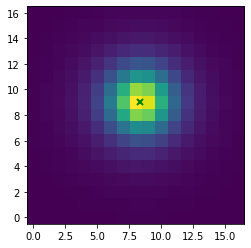

In [31]:
z = {"HE1353-1917":0.03521}

objs = z.keys()

for obj in objs:
    (Hb_blr_br_data,OIII_br_data,OIII_nr_data,amp_Hb_blr_br,amp_OIII_br,amp_OIII_nr,Hb_blr_br_err,OIII_br_err,OIII_nr_err) = flux_data_err(obj)
    box_size = np.shape(Hb_blr_br_data)[1]  
    x, y = np.mgrid[:box_size, :box_size]
    xy=(x,y)
    algorithm_script(obj,z[obj])

1.356066
HE0021-1810
1.356066
4 4
[0.06845002609878302, 4.567317383084536, 3.789412701712637, 2.290531178690127, 1.4251558865755496, 3.6256871035342493] [0.01416084 0.13210704 0.12938918 0.04008701 0.13002258 0.29526108]
[0.29744299 5.87448402 3.22837323] [0.06148875 0.27972071 0.15022335]
[0.58105382 4.92009772 3.81720793] [0.00830736 0.02562356 0.01655149]


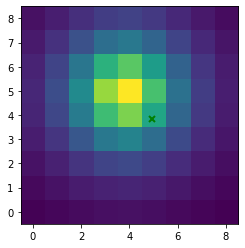

1.5679197
HE0021-1819
1.5679197
7 8
[0.05796341681982323, 8.132580289636586, 7.630181157194283, 3.6651766384441338, 2.738416918259744, 3.934135823538783] [0.00093516 0.01550474 0.01743257 0.11636601 0.1018032  0.04800475]
[0.35883918 8.28802948 7.38344165] [0.00095827 0.006354   0.00637755]
[1.93870717 8.02192383 7.46903635] [0.00216773 0.00326035 0.00300724]


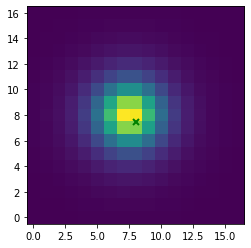

1.6406764
HE0040-1105
1.6406764
7 8
[0.3728908958578155, 7.807889078887103, 7.651026661239058, 3.356072701695019, 2.6807564965743453, 3.646054803098499] [0.00197967 0.00532315 0.00636951 0.03366222 0.03108809 0.01428713]
[0.63224691 7.67865149 8.19117109] [0.00268332 0.00899019 0.01017411]
[3.90330888 8.00757011 7.44104961] [0.00431792 0.00267529 0.00390274]


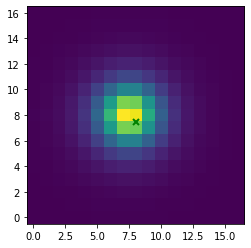

2.0286798
HE0108-4743
2.0286798
3 4
[1.2530271269124058, 4.035753106162071, 4.053519611356151, 3.2038089344459784, 2.4037219888131864, 3.7044845850325867] [0.04489554 0.03149732 0.03133771 0.31901323 0.30261331 0.11678289]
[2.28080106 4.12907257 3.75638265] [0.03027133 0.04916799 0.03658005]
[6.75228156 4.13897575 3.17487215] [0.02281993 0.00866686 0.01050542]


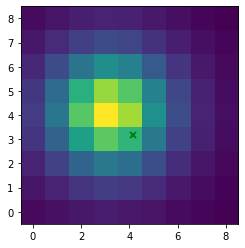

1.6333879
HE0114-0015
1.6333879
8 8
[0.12358589720634752, 7.391018255453252, 7.647621655577482, 3.0626212104594783, 3.16521039835527, 3.0307136590574952] [0.00357558 0.02216563 0.02460265 0.19509746 0.26230279 0.06246473]
[0.07936264 8.14037447 7.81419426] [0.00342475 0.09221037 0.07291923]
[0.62689352 7.5735718  7.70350882] [0.00320665 0.00984481 0.01069937]


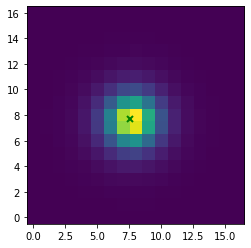

1.416731
HE0119-0118
1.416731
4 4
[1.688729491165105, 4.059388558364155, 4.116940037859876, 1.7902374259928826, 2.477107146740888, 2.034558338112651] [0.05476067 0.01312264 0.01437697 0.0685075  0.09183296 0.03837484]
[9.36145057 3.98112007 4.03338979] [0.03280827 0.00357708 0.00354384]
[13.92072101  3.98066294  4.10236769] [0.03607832 0.00308341 0.00323945]


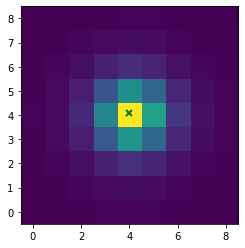

1.4458556
HE0212-0059
1.4458556
8 8
[0.2869950745955269, 7.634013467043391, 8.270165325312492, 2.6084717767395147, 1.8014409031954173, 3.5738228726841252] [0.00698368 0.01517835 0.01663825 0.05985353 0.02945285 0.05085513]
[0.24156904 8.9856336  8.4611903 ] [0.00370568 0.05421699 0.02100542]
[2.31948361 7.59959129 8.31841873] [0.0043707  0.00448001 0.00435885]


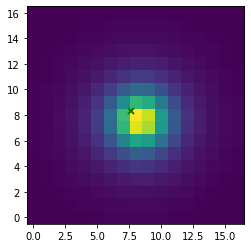

1.7209688
HE0224-2834
1.7209688
4 4
[0.3512774897994006, 3.9976985889316214, 3.8807782846686183, 4.260633470404471, 3.1401972524317894, 4.234917432719459] [0.0021937  0.0069987  0.00713622 0.11196118 0.11842836 0.02498893]
[0.98289947 3.93162987 3.92711201] [0.00500421 0.01378877 0.01287849]
[2.96473766 4.26811135 3.36189813] [0.00485327 0.00476932 0.00489428]


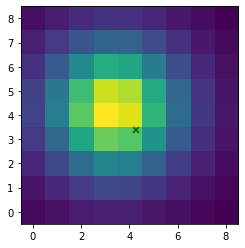

2.192149
HE0227-0913
2.192149
4 4
[7.206565122714446, 4.078958966738928, 4.003787126519882, 2.9088083506727527, 2.6047285566158025, 3.212251849308988] [0.08038149 0.00613604 0.00617835 0.05454039 0.05468841 0.02380615]
[0.62554213 4.16791162 4.09005666] [0.00611723 0.01940699 0.02129466]
[6.15692035 4.17225884 4.01865944] [0.00731246 0.00257521 0.00227764]


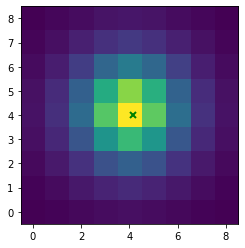

1.8799717
HE0232-0900
1.8799717
4 4
[7.774158879614357, 4.1105146514980655, 4.110648944930815, 2.7552474229806014, 2.574498123241969, 3.0629817743067695] [0.07431944 0.00445282 0.00378986 0.0331752  0.03149682 0.01663368]
[20.55667823  3.96994661  3.74807534] [0.23385425 0.01991872 0.02024006]
[49.72302392  3.3382159   4.05282215] [0.0933707  0.00352809 0.00187969]


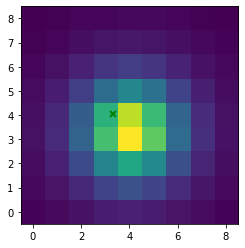

1.6392349
HE0253-1641
1.6392349
4 4
[2.7486778437351247, 3.775082002640937, 4.071482375304271, 2.486318975686115, 2.9633904685993064, 2.5526757911643094] [0.05450638 0.01193093 0.00961125 0.09049913 0.12693855 0.03443469]
[6.94512381 3.79865707 4.00804204] [0.01387911 0.00314213 0.00278709]
[22.04495884  3.53813923  3.94748477] [0.02644814 0.00214198 0.00170796]


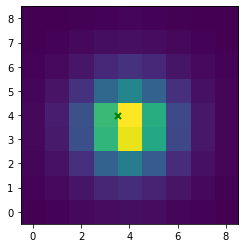

1.6350082
HE0345+0056
1.6350082
4 4
[29.173292606033673, 4.070084424927297, 4.1083069999237605, 2.253242049551951, 2.5951292119474214, 2.49353624909139] [0.31681649 0.00429764 0.00419849 0.02640217 0.02826145 0.01463827]
[11.7590837   4.01642507  4.113297  ] [0.02700184 0.00323579 0.00290298]
[21.60792281  3.96081714  4.10080676] [0.03797889 0.00254791 0.00209788]


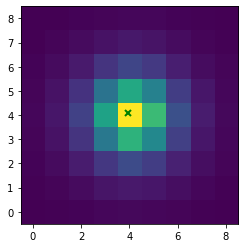

1.4870944
HE0351+0240
1.4870944
4 4
[3.756589400797582, 3.717209301386548, 3.935717617604714, 2.159390184488699, 3.061055797959148, 2.177145369247966] [0.02125369 0.00380653 0.00324723 0.02894151 0.05296237 0.00933494]
[2.31939873 3.72085479 3.91436042] [0.03777802 0.02752174 0.02410289]
[43.60698539  3.70288677  3.96365603] [0.04112629 0.00150974 0.00124116]


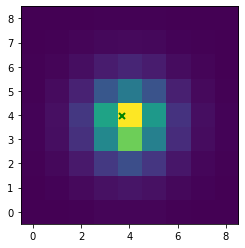

1.4179466
HE0412-0803
1.4179466
8 8
[1.640035367935223, 7.977050471449724, 7.959622587085535, 3.357936620645464, 2.4168290840966544, 3.870569809877061] [0.00476011 0.00217137 0.00233904 0.01193179 0.00805502 0.00686441]
[5.54052516 7.96978824 8.1595511 ] [0.0260278  0.01077075 0.01035536]
[52.85823354  8.05495249  8.37452954] [0.02567039 0.00242514 0.00183727]


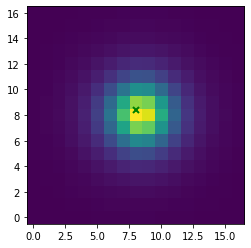

1.2614789
HE0429-0247
1.2614789
4 4
[1.8345622446511736, 3.824198293237597, 4.078284200498444, 2.4425522320052666, 2.6501871216422046, 2.670938841719201] [0.03390589 0.00928903 0.00711178 0.06906758 0.08080126 0.03176616]
[2.15430337 3.78872906 4.19644543] [0.01295319 0.00801537 0.0087477 ]
[10.64141568  3.86771057  3.85158691] [0.01481492 0.00195609 0.00226074]


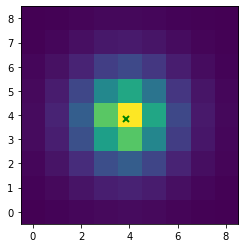

1.2710024
HE0433-1028
1.2710024
8 8
[2.6389219273404083, 8.126868673645847, 7.791577329855446, 2.624270324994698, 2.250317259794186, 3.1523195634268695] [0.0213597  0.00532579 0.00512943 0.021205   0.01595028 0.01407391]
[5.29055176 8.03050279 7.88793622] [0.0076417  0.00267366 0.00238557]
[5.27708427 8.21766518 7.83952722] [0.01065301 0.00342058 0.00338587]


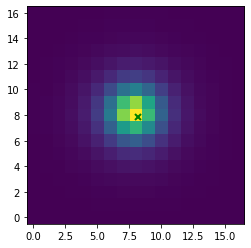

1.4730742
HE0853+0102
1.4730742
8 8
[0.18934147367789075, 8.310539328819662, 7.944718685399487, 2.90948456237102, 3.225525693425551, 2.849102336131255] [0.00259753 0.0094055  0.00939407 0.07477622 0.10499287 0.02533874]
[0.32452631 8.24372637 7.98212786] [0.00243343 0.01227943 0.01193869]
[1.13422847 8.48459468 8.15490598] [0.00320602 0.00538299 0.00398342]


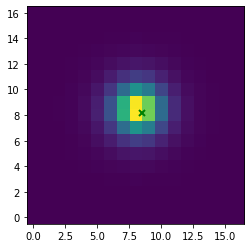

2.2774768
HE0934+0119
2.2774768
8 8
[0.9218602091382978, 7.560133782740385, 7.535302722240436, 3.1446144376770424, 2.2643216778866684, 3.763782137990197] [0.01194858 0.01167815 0.01215638 0.05051005 0.03489676 0.03061397]
[0.99931255 7.42861993 7.62785106] [0.00379887 0.00889087 0.00877686]
[2.22323608 7.6144242  7.43485083] [0.00379203 0.00423984 0.00370891]


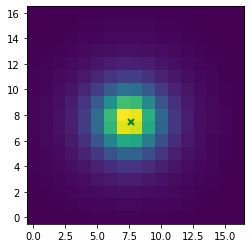

1.6947104
HE1011-0403
1.6947104
8 8
[0.8178525534314927, 7.845823507973143, 7.779667140969434, 3.8414474410944486, 2.597157264119297, 4.249222299294536] [0.0091612  0.01198858 0.011602   0.06743989 0.04923995 0.03207399]
[0.55078003 7.82867112 7.85539256] [0.00239309 0.0112653  0.00934541]
[1.23466139 7.78880244 7.74890779] [0.00284168 0.00646489 0.00631595]


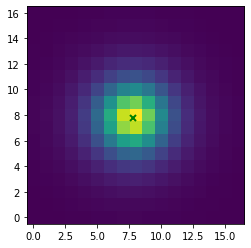

1.5494856
HE1017-0305
1.5494856
8 8
[0.6889994721504045, 7.991979223840355, 8.148756123302203, 3.567185490538608, 2.670990458668217, 3.883444579189669] [0.00469731 0.00576764 0.00593256 0.04066623 0.03366061 0.01789985]
[0.5452523  7.82947311 8.20058538] [0.00428173 0.0226298  0.02047429]
[1.39130831 8.06041617 8.09452693] [0.00706793 0.01042411 0.00968051]


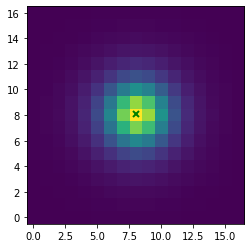

1.6829182
HE1029-1831
1.6829182
8 8
[0.38053580000693393, 8.216184831621696, 7.88239333496462, 3.2953636386329874, 2.4447807868989777, 3.773426082604902] [0.0073273  0.02112267 0.0192939  0.10112103 0.07914292 0.0522792 ]
[1.64326097 8.49965363 7.63173467] [0.00643057 0.01110721 0.0092403 ]
[0.42921756 8.07372545 8.34560844] [0.00464284 0.02331811 0.02186432]


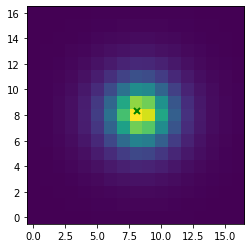

1.3308307
HE1107-0813
1.3308307
8 8
[0.9214488485459313, 7.928492591286294, 7.846128977360699, 3.1364294137753306, 2.5671652985989155, 3.4924157982741173] [0.01522485 0.01170955 0.01279423 0.05176048 0.03856523 0.03046161]
[0.13770368 7.98374989 7.97317287] [0.00293455 0.04192841 0.04149508]
[0.4576721  7.55787258 7.09352449] [0.00468791 0.01839074 0.03102488]


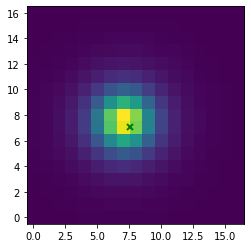

1.809293
HE1108-2813
1.809293
8 8
[1.611294896646309, 8.449573485466459, 7.9056140340532055, 2.2165650441776292, 2.5279903755648205, 2.4899176073383797] [0.01287073 0.00593633 0.00529545 0.02670178 0.0319868  0.01310783]
[2.11111193 8.46946058 8.1734556 ] [0.01314034 0.01029595 0.00814968]
[4.62639541 8.39570312 8.19272221] [0.01431629 0.00622542 0.00519133]


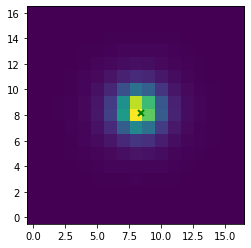

1.7090701
HE1126-0407
1.7090701
4 4
[10.636718286751716, 4.100470943747788, 3.8537345086276225, 1.9863447517244075, 2.7198337234853684, 2.1403430428929853] [0.20759158 0.00673772 0.00598569 0.03324505 0.04046026 0.01943711]
[2.84228516 4.09310172 3.91730633] [0.02590928 0.01016023 0.01047098]
[19.56024071  4.43034939  4.03035936] [0.03450221 0.00259824 0.00208701]


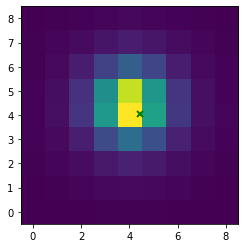

2.2745798
HE1237-0504
2.2745798
8 8
[2.6099925723684336, 8.272735010514051, 7.583868542866977, 2.5116473409602262, 2.3211598978212753, 2.9633125421252084] [0.00517814 0.00133135 0.00150605 0.00710255 0.00661784 0.00387468]
[2.04989072 8.24623098 7.41509626] [0.00582091 0.00490439 0.00447982]
[15.74482934  8.34569869  7.9967949 ] [0.00543384 0.00065903 0.00087902]


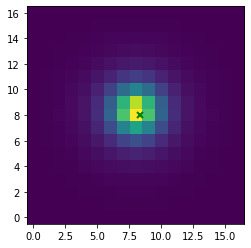

1.7084275
HE1248-1356
1.7084275
8 8
[0.16681006175778793, 7.636461523823127, 8.266059323447388, 3.5752325942868612, 4.0765128911849775, 3.0784023736951354] [0.00289538 0.0185998  0.01686587 0.26769335 0.48469884 0.04455368]
[0.63035621 7.53400748 8.37611421] [0.00501186 0.02107171 0.02152959]
[4.70404538 7.58830369 8.5875363 ] [0.0083826  0.0037562  0.00325265]


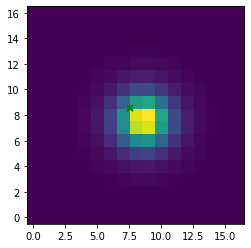

1.5501313
HE1330-1013
1.5501313
8 8
[0.3132534257013759, 7.836306609840305, 7.647014824371113, 3.260533901451081, 2.4187981117998003, 3.756537519078588] [0.00728407 0.02167732 0.02194657 0.10976798 0.08696591 0.0559546 ]
[0.15057754 8.05214945 7.48515134] [0.00244481 0.03993181 0.03767096]
[0.73608132 7.62559229 7.81339922] [0.00306958 0.00942371 0.01176619]


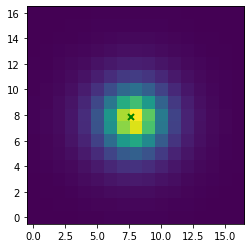

1.5308046
HE1353-1917
1.5308046
8 9
[0.12801649138951826, 7.539263615939289, 8.470360487719553, 3.6833696431004648, 2.6697568160429053, 4.010981157638467] [0.00209621 0.0176218  0.02022318 0.09681043 0.0776063  0.04559065]
[ 0.16370063  3.22793265 11.44805826] [0.00160497 0.04197657 0.03348803]
[1.55012722 9.05647014 8.36207942] [0.00396481 0.01583579 0.00855977]


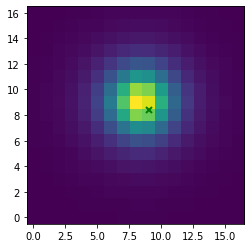

1.4628958
HE1417-0909
1.4628958
4 4
[1.6386204579675392, 4.158383431277395, 4.20381023215327, 1.8964735458401347, 2.630388849908109, 2.082659368587927] [0.01263209 0.00306559 0.00329952 0.02038315 0.0294211  0.01023686]
[3.01918841 4.10407229 4.29958094] [0.02128867 0.00984262 0.00899212]
[14.96069072  4.18464175  4.21683896] [0.02762488 0.00224753 0.00200073]


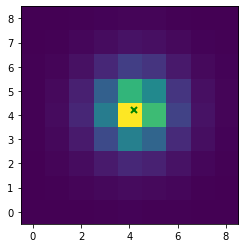

1.602829
HE2128-0221
1.602829
8 8
[0.24690749921387295, 7.47377355735669, 7.662434453783628, 3.7041695150703036, 2.884710729028925, 3.8609393623532577] [0.00197563 0.00872379 0.00863336 0.05498661 0.05110971 0.02144411]
[0.42908736 7.62006064 7.68170416] [0.00381005 0.02028026 0.01881628]
[1.74495905 7.7216689  7.70740922] [0.0032401  0.00691076 0.00516684]


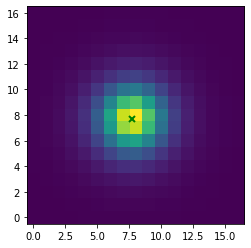

1.8953648
HE2211-3903
1.8953648
8 8
[0.3841779265469284, 7.827613614460971, 8.363037759612359, 2.669170154736524, 2.896343578168964, 2.775846958702411] [0.00313869 0.00679813 0.00629979 0.03728312 0.0457077  0.0161663 ]
[0.14711712 8.07872835 8.53496598] [0.00308187 0.0348606  0.04270993]
[3.68569804 8.04324976 8.34714555] [0.00421723 0.00167914 0.00232969]


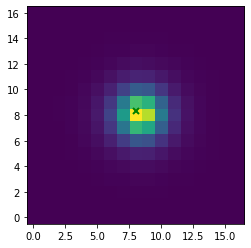

1.6834092
HE2222-0026
1.6834092
8 8
[0.18115047923855226, 7.928638333661875, 7.862924359555325, 3.2217397192916777, 2.56290446749376, 3.5908107310311297] [0.00312294 0.01131451 0.0111713  0.0887477  0.07370192 0.0423891 ]
[0.08198291 7.98801303 8.02583857] [0.00166498 0.03720734 0.03741025]
[0.43845603 7.96067658 7.82106124] [0.0015256  0.00704578 0.00703213]


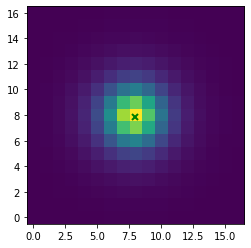

1.4602867
HE2233+0124
1.4602867
4 4
[0.22377811468717929, 3.9895136499836776, 3.98085293242465, 2.4355162905713663, 3.1595293576160937, 2.4125541264203343] [0.00701061 0.01986054 0.01636037 0.15436387 0.24971361 0.05147641]
[0.13574096 3.99678674 4.00586316] [0.0058394  0.04921376 0.05584901]
[1.04581032 3.98945185 3.87934524] [0.00676492 0.01029699 0.00778067]


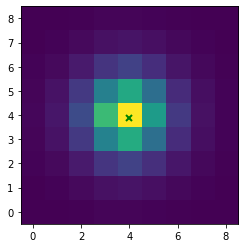

2.0455244
HE2302-0857
2.0455244
8 8
[1.3966429436875463, 7.803960846373578, 7.964599623187286, 3.116705067754632, 2.435861723428744, 3.5763490373905364] [0.02351244 0.0091329  0.0097305  0.04892884 0.03269183 0.03115688]
[1.23351253 7.87042777 8.33656584] [0.00959485 0.01644242 0.01531353]
[14.49619361  7.59473364  7.19695293] [0.01489782 0.00166457 0.0026789 ]


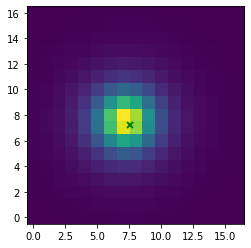

In [11]:
z = {"HE0021-1810":0.05352,"HE0021-1819":0.053197,"HE0040-1105":0.041692,"HE0108-4743":0.02392,"HE0114-0015":0.04560
    ,"HE0119-0118":0.054341,"HE0212-0059":0.026385,"HE0224-2834":0.059800,"HE0227-0913":0.016451,"HE0232-0900":0.043143
    ,"HE0253-1641":0.031588,"HE0345+0056":0.031,"HE0351+0240":0.036,"HE0412-0803":0.038160,"HE0429-0247":0.042009
    ,"HE0433-1028":0.035550,"HE0853+0102":0.052,"HE0934+0119":0.050338,"HE1011-0403":0.058314,"HE1017-0305":0.049986
    ,"HE1029-1831":0.040261,"HE1107-0813":0.058,"HE1108-2813":0.024013,"HE1126-0407":0.061960,"HE1237-0504":0.009
    ,"HE1248-1356":0.01465,"HE1330-1013":0.022145,"HE1353-1917":0.035021,"HE1417-0909":0.044,"HE2128-0221":0.05248
    ,"HE2211-3903":0.039714,"HE2222-0026":0.059114,"HE2233+0124":0.056482,"HE2302-0857":0.046860}

objs = z.keys()

for obj in objs:
    (Hb_blr_br_data,OIII_br_data,OIII_nr_data,amp_Hb_blr_br,amp_OIII_br,amp_OIII_nr,Hb_blr_br_err,OIII_br_err,OIII_nr_err) = flux_data_err(obj)
    box_size = np.shape(Hb_blr_br_data)[1]  
    x, y = np.mgrid[:box_size, :box_size]
    xy=(x,y)
    algorithm_script(obj,z[obj])